## Word Emeddings for Document Similarity

This notebook will introduce some code for training a Word2Vec model on the DBPedia corpus.

* Train a Word2Vec model with gensim
* Extract the embeddings
* Create a t-SNE plot of the embeddings
* Use the embeddings for document similarity.

#### Load the necessary libraries

In [1]:
%matplotlib inline
from sklearn.feature_extraction import stop_words
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from scipy import spatial
from gensim import utils
import numpy as np
import gensim
import random
import time
import zipfile

#### Load the text file containing the wikipedia abstracts and set up functions to clean the text

In [2]:
with zipfile.ZipFile('data/dbpedia.zip', 'r') as db_zip_file:
    with db_zip_file.open('dbpedia/dbpedia.txt', 'r') as f:
        sentences = f.readlines()

def strip_non_ascii(string):
    # returns the string without non ASCII characters
    stripped = ([c if 0 < ord(c) < 128 else ' ' for c in string])
    return ''.join(stripped).split()

clean_text = []
for  text in sentences:
    # remove non ascii characters
    all_ascii = strip_non_ascii(text.decode().lower())
    # remove stop words
    no_stops = [w for w in all_ascii if w not in stop_words.ENGLISH_STOP_WORDS]
    # remove all punctuation and numbers that are left
    cleaned = [w for w in no_stops if w.isalpha()]
    # append clean text to list
    if len(cleaned) > 0:
        clean_text.append(cleaned)

print(clean_text[0])

['abbott', 'abbott', 'farnham', 'e', 'd', 'abbott', 'limited', 'british', 'coachbuilding', 'business', 'based', 'farnham', 'surrey', 'trading', 'major', 'output', 'motor', 'vehicle', 'business', 'closed']


### Do the training and save the model for later

With word2vec it is possible to use a pretrained model and simply extract the embeddings for each word in your corpus. However, the downside here is that words have different meanings in different contexts. For example if we were trying to come up with some embeddings for machine learning a pretrained model will get python wrong. It will give python a vector that is closest to snake and reptile vectors and not one that is like a programming language. 

For this specific example we are using wikipedia abstracts and the word2vec model was pretrained on millions of news articles so it may be a good match. But, we've got enough data to retrain and this is a tutorial. 

In [16]:
# model params
ITERS = 10
num_features = 64
min_word_count = 20
num_workers = 4

print('Creating Word2Vec ... ')
model = gensim.models.Word2Vec(size=num_features, workers=num_workers, iter=1, window=10,
                               min_count=min_word_count, sg=1)
print('Building vocab ...')
model.build_vocab(clean_text)

# initialize the word2vec model
#model = gensim.models.Word2Vec(size=num_features, workers=num_workers, iter=80
#                               min_count=min_word_count, sg=1, min_alpha=0.00001)
print('Training word2vec ... ')
for epoch in range(ITERS):
    start = time.time()
    # shuffle text on each iteration
    text = shuffle(clean_text)
    model.train(text, total_examples=model.corpus_count, epochs=1)
    if model.alpha > 0.0001:
        model.alpha -= 0.0002
    end = time.time()
    print('Iter:', epoch, 'Time:', end-start, 'Model LR:', model.alpha)

#print 'Saving model ... '
model.save('dbpedia_w2v_model')

Creating Word2Vec ... 
Building vocab ...
Training word2vec ... 
Iter: 0 Time: 29.836277961730957 Model LR: 0.024800000000000003
Iter: 1 Time: 30.803873777389526 Model LR: 0.024600000000000004
Iter: 2 Time: 29.19654607772827 Model LR: 0.024400000000000005
Iter: 3 Time: 29.27795958518982 Model LR: 0.024200000000000006
Iter: 4 Time: 28.990219354629517 Model LR: 0.024000000000000007
Iter: 5 Time: 28.91030263900757 Model LR: 0.02380000000000001
Iter: 6 Time: 28.968107223510742 Model LR: 0.02360000000000001
Iter: 7 Time: 28.98922610282898 Model LR: 0.02340000000000001
Iter: 8 Time: 28.98980975151062 Model LR: 0.023200000000000012
Iter: 9 Time: 28.97021770477295 Model LR: 0.023000000000000013


### Make a t-SNE plot of some of our words

t-SNE is a good way to visualize high dimensional data. Making these plots for embeddings or any kind of representation extracted from a deep learning model will give you some insight as to whether the model is learning useful features. 

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.379776
[t-SNE] KL divergence after 100 iterations with early exaggeration: 2.633614
[t-SNE] Error after 175 iterations: 2.633614


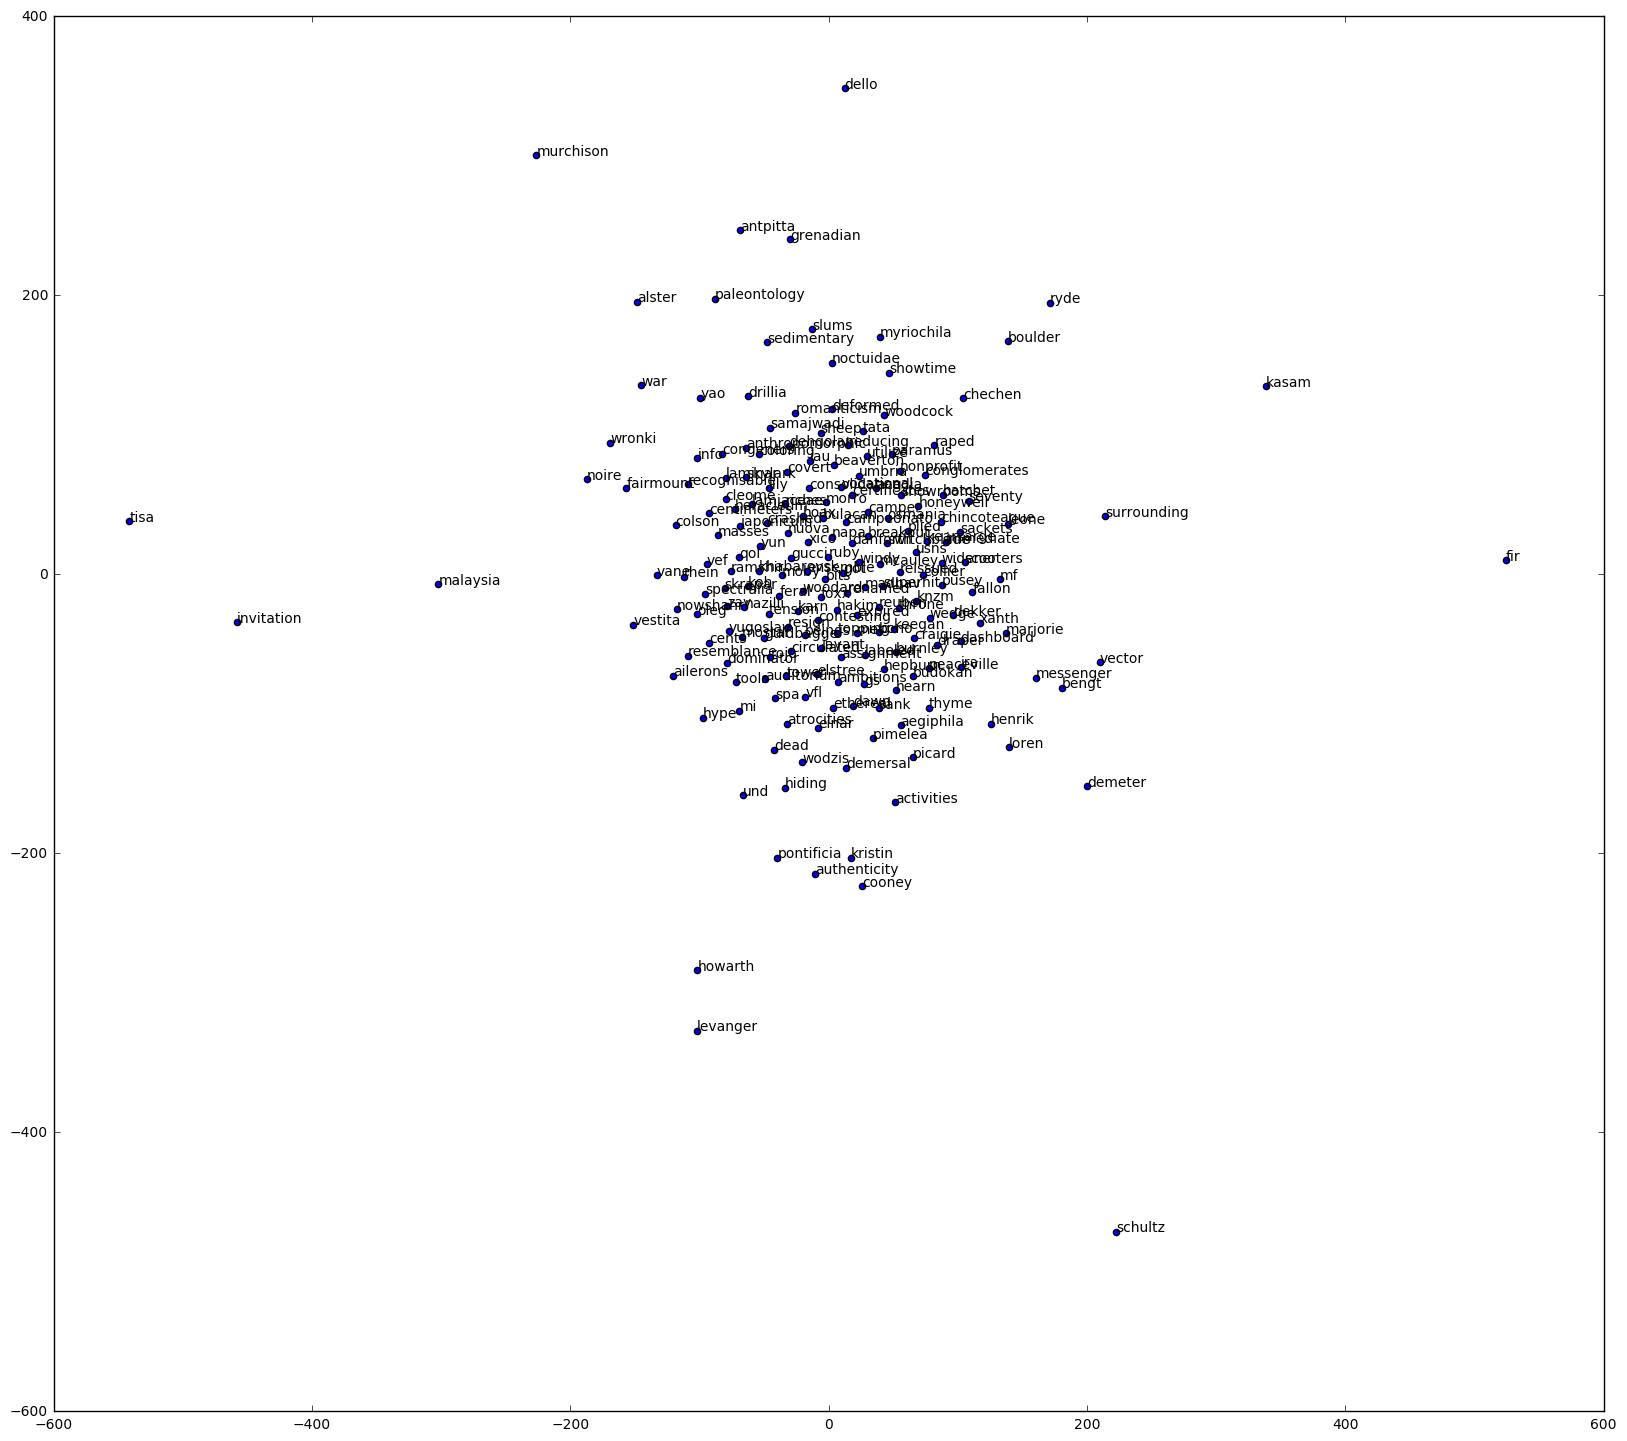

In [19]:
from sklearn.manifold import TSNE
#from tsne import bh_sne

plt.rcParams['figure.figsize'] = (20, 18)

# load the word2vec model that we trained above and normalize the weights so that the memory footprint is smaller
model = gensim.models.Word2Vec.load("dbpedia_w2v_model")
model.init_sims(replace=True)

#model = gensim.models.Word2Vec.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

# extract a vocab of 200 words from the model
vocab = list(model.wv.vocab.keys())[:200]

# note that the w2v from google uses vectors of size 300
# we used vectors of size 64
wv = np.zeros((len(vocab), 64))
for i, key in enumerate(vocab):
    wv[i] = model.wv[key].reshape(1, 64)
    
wv = np.nan_to_num(wv)

tsne = TSNE(n_components=2, random_state=0, verbose=1)
y = tsne.fit_transform(wv)

plt.scatter(y[:,0], y[:,1])
for label, x, y in zip(vocab, y[:,0], y[:,1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0), textcoords='offset points')
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.show()


#### Load the trained model



In [2]:

# load the word2vec model that we trained above and normalize the weights so that the memory footprint is smaller
model = gensim.models.Word2Vec.load("dbpedia_w2v_model")
model.init_sims(replace=True)

# or we can load the pretrained word2vec model from google. 
# a good exercise to compare the results
#model = gensim.models.Word2Vec.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

#### Set up some functions for making document comparisons

We only need to account for each word once so we have a uniqify function. 

We need a function to extract the embeddings from the trained model. With gensim's word2vec we simply just pass a string to the trained model and it will return the vector embedding. 

Come up with an algorithm to comparing documents. The one that I came up here was to compare each unique word in a query document to each word in the potential matching documents. When using the vector representations of words from word2vec we often use cosine similarity to find the most similar words. So I do each pair-wise comparison with cosine similarity. Calling this algorithm d-WAM for document word angle measurement. 

A labeled line sentence function to be consistent with gensim conventions. 

### Do the document similarity search

We'll take an abstract to use as our query document. We are using the abstract for the Cash Money Records wikipedia article. 

* Load the dbpedia text document
* Label the sentences and convert it to an array
* Clean the the query abstract
* For each abstract calculate it's similarity metric against cash money records 
* Print the top ten most similar abstracts to see how we did

In [5]:
length = 200


# choose the first sentence
target = "Cash Money Records LLC is an American record label founded by brothers Bryan Birdman Williams and Ronald Slim Williams who currently act as CEOs. Today it operates as a subsidiary of Universal Music Group and is distributed by Republic Records formerly Universal Republic. The label currently includes artists such as Lil Wayne Drake Tyga Nicki Minaj Ace Hood Busta Rhymes DJ Khaled Jay Sean Kevin Rudolf Limp Bizkit and Mystikal among others."

# function to clean text
def clean_sentence(sent):
    return [w for w in sent.lower().split() if w in model.wv.vocab and w not in stop_words.ENGLISH_STOP_WORDS]

scores = {}
for index, sentence in enumerate(clean_text):
    #sentence = clean_sentence(sentence)
    if len(sentence) > 0:
        #if index % 100 == 0: print index
        scores[index] = model.wv.wmdistance(clean_sentence(target), sentence)

sorted_list = sorted(scores.items(), key=lambda kv: kv[1])
top = sorted_list[:10]

print(target)
for index, score in top:
    print("\n")
    print(' '.join(clean_text[index]))


Cash Money Records LLC is an American record label founded by brothers Bryan Birdman Williams and Ronald Slim Williams who currently act as CEOs. Today it operates as a subsidiary of Universal Music Group and is distributed by Republic Records formerly Universal Republic. The label currently includes artists such as Lil Wayne Drake Tyga Nicki Minaj Ace Hood Busta Rhymes DJ Khaled Jay Sean Kevin Rudolf Limp Bizkit and Mystikal among others.


best music group best music group record label founded dj previously imprint music label signed partnership label cash money records imprint ymcmb family distributed republic current artists signed best include khaled ace hood mavado vado


aftermath entertainment aftermath entertainment american record label founded hip hop artist producer operates subsidiary distributed universal music interscope current acts include dre eminem kendrick lamar jon connor acts including cent busta rhymes game eve raekwon rakim slim mobster stat quo


bad boy record